<font size=6  color=#003366> <b>[LEPL1109] - STATISTICS AND DATA SCIENCES</b> <br><br> 
<b>Hackathon 04 - Clustering: What is it all about?</b> </font> <br><br><br>

<font size=5  color=#003366>
Prof. D. Hainaut<br>
Prof. L. Jacques<br>

<br><br>
Anne-Sophie Collin   (anne-sophie.collin@uclouvain.be)<br> 
Cécile Hautecoeur    (cecile.hautecoeur@uclouvain.be)<br> 
Guillaume Van Dessel (guillaume.vandessel@uclouvain.be)<br> 
Loïc Van Hoorebeeck  (loic.vanhoorebeeck@uclouvain.be)<br> 
<div style="text-align: right"> Version 2020</div>

<br><br>
</font>

<font size=5 color=#009999> <b>GUIDELINES & DELIVERABLES</b> </font> <br>
-  This assignment is due on the <b>21 December 2020 at noon</b>.
-  Copying code or answers from other groups (or from the internet) is strictly forbidden. <b>Each source of inspiration (stack overflow, git, other groups,...) must be clearly indicated!</b>
-  The notebook (with the "ipynb" extension) file and all other files that are necessary to run your code must be delivered on <b>Moodle</b>. Answer to the questions in this notebook in the markdown cells provided for that purpose. <br><br>


<font size=5 color=#009999> <b>CONTEXT & NOTEBOOK STRUCTURE</b> </font> <br>
    
The objective of this hackathon is to develop an unsupervised text clustering tool. Given a large dataset containing documents (questions posted on a forum) relative to different topics, you should be able to group texts belonging to similar topics.<br><br> 

<img src="Imgs/text_clustering.png" width = "400">

Such text content is everywhere : emails, chat conversations, websites, and social media. Assigning categories to documents has many applications like spam filtering, email routing, sentiment analysis, etc. <br>
Text can be an extremely rich source of information. However, extracting insights from it can be hard and time-consuming due to its unstructured nature. Natural Language Processing (NLP) is a branch of artificial intelligence that deals with the interaction between computers and humans using the natural language. It has for objective to read, understand and make sense of the human languages in a manner that is valuable. Recently, Text classifiers with NLP have proven to be a great alternative to structure textual data in a fast, cost-effective, and scalable way.<br><br> 

This notebook is organized into three parts. Each of them assesses one fundamental step to solve our problem and provides one visualization tool to gain some understanding:
* PART 1 - TEXT PREPROCESSING
   - 1.1 - Import the data
   - 1.2 - Text data preprocessing
   - 1.3 - Preliminary visualization tool 
    <br><br>
* PART 2 - THE FEATURE MATRIX 
   - 2.1 - Tf-idf model
   - 2.2 - Visualization of the tf-idf model 
    <br><br>
* PART 3 - IT'S TIME TO ... CLUSTER!
   - 3.1 - Text clustering
   - 3.2 - Results analysis 
   
We filled this notebook with preliminary (trivial) code. This practice makes possible to run each cell, even the last ones, without throwing warnings. <b>Take advantage of this aspect to divide the work between all team members!</b> <br><br>

<br><font size=7 color=#009999> <b>PART 1 - TEXT PREPROCESSING</b> </font> <br><br>

<font size=5 color=#009999> <b>1.1 - IMPORT THE DATA</b> <br>
"Transfer Learning on Stack Exchange Tags" dataset
</font> <br> <br>

In this __[dataset](https://www.kaggle.com/c/transfer-learning-on-stack-exchange-tags/notebooks)__, you are provided with question titles, contents, and tags for Stack Exchange sites on a variety of topics (biology, cooking, cryptography, diy, robotics, and travel). The content of each question is given as HTML. The tags are words that describe the topic of the question.

<div class="alert alert-info">
<b>[Remark] Consider only a part of the dataset</b>  <br>
For computational and memory issues, we suggest you to work with a part of this data set (typically 3 topics). The code below allows you to select the topics (crypto, cooking, travel by default) you want to process and store corresponding data in a dictionnary. 
Moreover, for memory purpose, we will work on the title of the question excusively (the content of the question will not take part in the clustering process). Also, for the same reason, we consider the first 5000 questions of each topic. 
</div> 

In [1]:
"""
CELL N°1 : IMPORT THE DATASET
[To do] You can modify the 3 topics that you will process (by default : crypto, cooking & travel)
"""

import numpy as np 
import pandas as pd 

# All topics considered in the dataset -> choose 3 of them by setting the dictionnary value to "True"
expConsidered = {'biology': False, 
                 'robotics': False, 
                 'crypto': True, 
                 'diy': False, 
                 'cooking': True, 
                 'travel': True}

# Construct our (reduced in size) dataset
#We reduced even more to save memory (5000 was over the notebook's allocated RAM)
data = {}
for thisLabel in expConsidered: 
    if expConsidered[thisLabel]:
        filePath        = 'Data/' + thisLabel +'.csv'
        data[thisLabel] = pd.read_csv(filePath, usecols = ['title'], nrows=2500)

# Print some examples
data['crypto'][0:10]

title
0  What are the benefits of the two permutation t...
1  Why use a 1-2 Oblivious Transfer instead of a ...
2  Why do we append the length of the message in ...
3  What is the general justification for the hard...
4  How can I use asymmetric encryption, such as R...
5          How were the DES S-box values determined?
6  How to provide secure "vanity" bitcoin address...
7  How can a random salt for a hash function work...
8  What are the practical differences between 256...
9  What makes a hash function good for password h...

<br>
<font size=5 color=#009999> <b>1.2 - TEXT DATA PREPROCESSING</b> <br>
REMOVING UNNECESSARRY INFORMATION AND RETURN THE ROOTS OF THE WORDS
</font> <br> <br>

Not surprisingly, we cannot directly feed our text into our unsupervided clustering algorithms. We need to represent our data in an exploitable way for the clustering tools. Before developing the model, we need to perform an extensive preprocessing step over our dataset:

1. **Data Cleaning** In order to avoid introducing bias in the word frequency analysis, we will remove unwanted (sequences of) charaters: 
    - Dealing with uppercase & lowercase letters;
    - Removing punctuation;
    - Apostrophe removal;
    - Split attached words.<br>
    
<div class="alert alert-info">
<b>[Remark] Regular Expressions </b>  <br>
The last 3 steps have been implemented with regular expressions. As detailed in this __[article](https://towardsdatascience.com/regular-expressions-in-python-a212b1c73d7f)__ ("Towards data science" blog), Regular expressions <i>are a generalized way to match patterns with sequences of characters. They define a search pattern, mainly for use in pattern matching with strings, or string matching, i.e. “find and replace” like operations.</i><br>
Do not hesistate to read more about regular expressions. These tools are extremely useful. 
</div> 

2. **Stopword Removal** Discarding too common words or words which are not going to be helpful in our analysis  (such as “the”, “a”, “an”, “in”).
3. **Data Tokenization** Segregation of text into individual words i.e tokens.
4. **Stemming** Combining different variants of words into a single parent word that conveys the same meaning. For example, "playing", "plays" and "played" are mapped to "play"; "am", "are", "is" are mapped to "be". 

In [2]:
"""
CELL N°2 : TEXT DATA PREROCESSING
[To do] Read the code bellow to understand how the text data preprocessing can be implemented. Then, run the cell.
"""

import regex as re
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk import pos_tag
lemmatizer = WordNetLemmatizer()

# Map POS tag to first character lemmatize() accepts
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Stop words
stops = set(stopwords.words("english"))

def clean_title(table):
    title = table.title
    # Converting text to lowercase characters
    title = title.apply(lambda x: x.lower())
    # Removing any character which does not match to letter,digit or underscore
    title = title.apply(lambda x: re.sub(r'^\W+|\W+$',' ',x))
    # Removing space,newline,tab
    title = title.apply(lambda x: re.sub(r'\s',' ',x))
    # Removing punctuation
    title = title.apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
    # Tokenizing and Stemming data + stop word removal
    title = title.apply(lambda x: [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(x) if w not in stops] )
    return(title)

# Apply our preprocessing method and observe the resultFccr
for df in data:
    data[df].title = clean_title(data[df])

data['crypto'][0:10]

title
0             [benefit, two, permutation, table, de]
1  [use, 1, 2, oblivious, transfer, instead, 1, n...
2  [append, length, message, sha, 1, pre, process...
3  [general, justification, hardness, find, preim...
4  [use, asymmetric, encryption, rsa, encrypt, ar...
5                        [de, box, value, determine]
6  [provide, secure, vanity, bitcoin, address, se...
7     [random, salt, hash, function, work, practice]
8  [practical, difference, 256, bit, 192, bit, 12...
9       [make, hash, function, good, password, hash]

<br>
<font size=5 color=#009999> <b>1.3 - PRELIMINARY VISUALIZATION TOOL</b> <br>
WORD CLOUD
</font> <br> <br>

Below, we propose a visualizing tool named "word cloud" allowing to summarize the content of multiple texts. A word cloud is an image made of words that together resemble a cloudy shape. The size of a word shows how important it is e.g. how often it appears in a text.

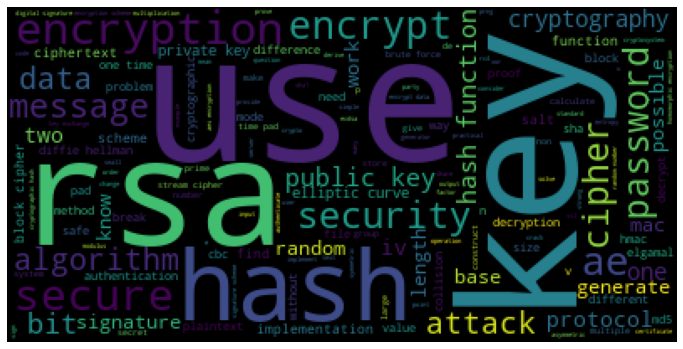

In [3]:
"""
CELL N°3 : WORD CLOUD
[To do] This is only an original tool to represent your data. Run the cell and observe the result.
"""

from wordcloud import WordCloud 
import matplotlib.pyplot as plt

text = ' '
for x in data['crypto'].title:
    for y in x:
        text+=' ' + y
        
plt.figure(figsize=(12,15))
wc = WordCloud(max_words=1000,random_state=1).generate(text)
plt.imshow(wc)
plt.axis('off')
plt.show()

<br>
<font size=7 color=#009999> <b>PART 2 - THE FEATURE MATRIX<b> </font> <br><br>

<br>
<font size=5 color=#009999> <b>2.1 - TF-IDF MODEL</b> <br>
CONVERT TEXT SENTENCES INTO NUMERIC VECTORS
</font> <br> <br>

TF-IDF stands for “Term Frequency - Inverse Document Frequency”. TF-IDF is intended to reflect how relevant a term is in a given document. Intuitively, a word that occurs many times in a document should be relevant compared to very rare words. However, a word that appears too often in a document, but also along many other documents, may be irrelavant to characterize the document's topic. 

Based on this intuition, each word in the corpus (technical term that refers to all texts considered - here, the corpus is the processed 'data' dictionnary) will receive a weight measure computed by the product of two terms: 
1. **Normalized Term Frequency (tf)** given by: <br>
    TF = (Number of repetitions of word in a document) / (# of words in a document)
2. **Inverse Document Frequency (idf)** given by : <br>
    IDF =Log[(# Number of documents) / (Number of documents containing the word)]
    
Based on this formula, we are able to construct an $m \times n$ matrix where $m$ is the number of documents and $n$ the number of words in the corpus. The columns of the matrix represent then the feature space in which we will perform the clustering. 
For more detailed explanations, refer to this __[post](https://www.freecodecamp.org/news/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04/)__.

<div class="alert alert-info">
<b>[Remark] Obtain the tfidf matrix</b>  <br>
Use the __[<samp>TfidfVectorizer</samp>](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)__ methods to obtain the vectorized representation of data. <b>Read carefully the documentation and the example provided in the web page linked previously!!!</b> <br>
A couple things to note about the parameters:
<ol>
   <li> **max_df**: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    <li> **max_features**: If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
    <li>  **use_idf**: Enable inverse-document-frequency reweighting.
</ol>
</div> 


<div class="alert alert-warning">
<b>[Question 1.1] Creation of the data (also called tfidf) matrix </b>  <br>
Use the <samp>TfidfVectorizer</samp> function from the <samp>sklearn.feature_extraction.text</samp> to create two tfidf matrices : 
<ol>
   <li> <samp>XFull</samp> of dimension $m \times n$ where $m$ is the number of documents and $n$ the vocabulary size. In this case $n$ in the number of different words in the corpus. 
   <li> <samp>X50</samp> of dimension $m \times 50$ where $m$ is the number of documents. We consider here a vocabulary of 50 words which is somehow a light version of <samp>XFull</samp>.
</ol>
</div> 

In [4]:
"""
CELL N°4 : TFIDF MATRIX
[To do] Construct the X50 and XFull matrices with the tf-idf model to replace our random features. 
"""
from sklearn.feature_extraction.text import TfidfVectorizer

#Fonction pour retourner une liste sous forme de string
#Inpirée de https://www.geeksforgeeks.org/python-program-to-convert-a-list-to-string/
def listToString(s):  
    str1 = " "    
    return (str1.join(s)) 


corpus = []
#Données que nous allons exploiter
for thisLabel in expConsidered: 
    if expConsidered[thisLabel]:
        #On prend chaque liste qu'on reformate sous forme d'un string 
        #On ajoute le string au corpus 
        #De cette manière il n'y a plus de soucis
        for list in data[thisLabel].title:
            corpus.append(listToString(list))

#On ne garde que les 50 premières occurences
vectorizerX50 = TfidfVectorizer(max_features=50)
X50 = vectorizerX50.fit_transform(corpus)

#Pas de limitations
vectorizerXFull = TfidfVectorizer()
XFull = vectorizerXFull.fit_transform(corpus)

nullvectorsX50 =0 #Nombre de vecteurs nul pour X50
for vectors in X50:
    if(vectors.getnnz()==0):#Fonction qui retourne le nombre de terme différent de 0 dans un vecteur
        nullvectorsX50+=1

nullvectorsXFull =0#Nombre de vecteurs nul pour XFULL
for vectors in XFull:
    if(vectors.getnnz()==0):#Fonction qui retourne le nombre de terme différent de 0 dans un vecteur
        nullvectorsXFull+=1
#print(vectorizerX50.get_feature_names())
print("Number of null vectors in X50 is "+ "%01d" %nullvectorsX50)
print("Number of null vectors in XFull is "+"%01d" % nullvectorsXFull)

Number of null vectors in X50 is 2734
Number of null vectors in XFull is 0


<div class="alert alert-warning">
<b>[Question 1.2] All-zero representations? </b>  <br>
For these two configurations (<samp>X50</samp> and <samp>XFull</samp>), count the number of documents whose encoded vector is the null vector [0,0,...0]. Why are they such vectors? How will them be treated by the clustering algorithm? (+/- 10 lines)
</div> 

Le nombre de vecteurs null pour XFull est de 0. Cela car chaque vecteur contient au moins un mot. La matrice XFull est cependant très creuse car les vecteurs contiennent au moint un mot mais pas énormement. Dès lors chaque vecteur contient bien plus de 0 que d'autres chiffres. 

Le nombre de vecteurs null pour X50 est bien supérieur car on ne considère plus que les 50 mots qui ont le plus d'occurences. Il y a donc bien plus de chance d'avoir plusieurs vecteurs qui ne contiennent aucun de ces mots. 

TODO HOW IT WILL BE TREATED

<br>
<font size=5 color=#009999> <b>2.2 - VISUALIZATION OF THE TF-IDF MODEL</b> <br>
REDUCE THE DIMENSIONALITY OF THE DATA FOR VISUALIZATION
</font> <br> <br>

The high dimensionality of the tfidf matrix (dimension of size $n$ for <samp>XFull</samp> or 50 for <samp>X50</samp>) makes data visualization hard. In order to gain some (partial) information about our data distribution, we propose to perform a 3-dimensional visualization of them. For this purpose, we need to reduce dimensionality of our feature space while keeping as much information as possible about the data. 

PCA is often considered as the simplest and most fundamental technique used in dimensionality reduction. Remember that PCA is essentially the rotation of coordinate axes, chosen such that each successful axis captures or preserves as much variance as possible. If the algorithm returns a new system coordinates of the same dimension as the input, we can keep only the axis corresponding to the 3 largest singular values and project data on this coordinate system to perform the visualization.


![PCAUrl](https://miro.medium.com/max/400/1*ZXhPoYQIn-Y8mxoUpz5Ayw.gif "PCA")

<div class="alert alert-info">
<b>[Remark] Low-rank approximation of the tf-idf matrix with Truncated SVD</b>  <br>
One of the major drawbacks of the PCA decomposition is the need to strore the covariance matrix of the data. In our applicative context, this lead to heavy computations that are not optimized for sparse matrices. Instead, we suggest you to consider any decomposition which is particularly efficient on sparse data : the truncatedSVD. To obtain the decomposition, use the <samp>TruncatedSVD</samp> methods of the <samp>sklearn.decomposition</samp> library. 
</div> 


** Difference between PCA/SVD and Truncated SVD : linear algebra explanation **

The SVD decomposition of a matrix $X \in \mathbb{R}^{m \times n}$ with $m \gg n$ is of the form :

$$ X = U \Sigma V^{\text{T}} $$

where $ U \in \mathbb{R}^{n \times n}$, $ V \in \mathbb{R}^{m \times m}$ and $ \Sigma \in \mathbb{R}^{n \times m}$ is a matrix with nonnegative entries on the diagonal and zeros off the diagonal. The columns of $U$ are called left singular vectors of $X$ and the columns of $V$ are right singular vectors. The diagonal elements of $\Sigma$ are called singular values and the are ordered from largest to smallest. For matrix $X$ of rank $r$, there are exactly $r$ non zero singular values. 

Perhaps the most useful and defining property of the SVD is that it provides an optimal low-rank approximation to a  matrix $X$. In fact, the SVD provides a hierarchy of lowrank approximations, since a rank-$r$ approximation is obtained by keeping the leading $r$ singular values and vectors, and discarding the rest.

The truncated SVD decomposition allows to compute a row-$k$ approximation of $X$ for a choosen $k$ parameter that is usually small and less than $r \leq n $. The truncated SVD only approximates X:

$$ X \approx U_k^* \Sigma_k^* V_k^{*\text{T}} $$

where $ U \in \mathbb{R}^{n \times k}$, $ V \in \mathbb{R}^{k \times m}$ and $ \Sigma \in \mathbb{R}^{k \times k}$. 

<div class="alert alert-warning">
<b>[Question 2] Preliminary data visualization </b>  <br>
Use the <samp> groupVisualization </samp> function provided below to perfom a 3-dimensional scatter plot of the data depending of the topic associated to the title's topic. Do this analysis for both <samp>XFull</samp> and <samp>X50</samp>.<br>
Does the clustering problem seems to be difficult? Are the clusters separable? <br>
Answer to these questions below (5-10 lines). 
</div> 

Insert here your answer to Question 2



In [5]:
"""
CELL N°5 : TFIDF MATRIX VISUALIZATION
[To do] Apply PCA on both X50 and XFull. Keep the 3 most relevant PCA components (or new features) to reduce
        the dimensionality of the two data matrices. Then, plot the samples in the coordinate space of the 3 most 
        relevant components with the groupVisualization function. 
"""

import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)


from sklearn.decomposition import TruncatedSVD

""" -----------------------------------------------------------------------------------------
3D Vizualisation of samples (color depends on the real topic = Ground Truth)
INPUT : 
    - data: intitial data dictionnary
    - X [Mx3]: data coordinates (in low dimensional space) after PCA
    - (lessPoitns=False. If True, Display a random subset of points instead of the entire documents samples.
    You can change it if you observe memory issues with your computer of very slow interractivity with the plot.)
----------------------------------------------------------------------------------------- """ 

def groupVisualization(data, X, lessPoints=True):
    colors      = iter(['gold','mediumaquamarine','midnightblue'])
    all_3dplots = []
    start       = 0
    for label in data: 
        if lessPoints:     # Plot only a random subset of points
            selectedPoints = np.random.choice(len(data[label]['title']), 1000) + start 
        else:              # Display all points 
            selectedPoints = range(start, start+ len(data[label]['title']) )
        temp_cluster3d = go.Scatter3d(
                                x = X[selectedPoints,0],
                                y = X[selectedPoints,1],
                                z = X[selectedPoints,2],
                                mode = 'markers',
                                opacity = 0.7,
                                name = label,
                                marker = dict(
                                            size = 5,
                                            color = next(colors)
                                )
        )
        start += len(data[label]['title'])
        all_3dplots.append(temp_cluster3d)
    fig_3d = go.Figure(data = all_3dplots)
    iplot(fig_3d)
    
#On définie l'outil qu'on utilisera pour tronquer en d 
svd = TruncatedSVD(n_components=3,n_iter=5)
XFullTransf = svd.fit_transform(XFull)
X50Transf = svd.fit_transform(X50)


print('-'*75 + '\n', "Visualization of X50 \n", '-'*75 + '\n')
groupVisualization(data, X50Transf)
print('-'*75 + '\n', "Visualization of XFull \n", '-'*75 + '\n')
groupVisualization(data, XFullTransf)

---------------------------------------------------------------------------
 Visualization of X50 
 ---------------------------------------------------------------------------



---------------------------------------------------------------------------
 Visualization of XFull 
 ---------------------------------------------------------------------------



<br>
<font size=7 color=#009999> <b>PART 3 - IT'S TIME TO ... CLUSTER!</b> </font> <br><br>

<br>
<font size=5 color=#009999> <b>3.1 - TEXT CLUSTERING</b> <br>
THE K-MEANS ALGORITHM
</font> <br> <br>

Clustering can be defined as the task of grouping a set of objects in such a way that objects in the same group (called cluster) are more similar (in some sense or another) to each other than to those in other groups (clusters).


In other words, this corresponds to finding, among all $K$-partitions $C_1 \cup C_2 \cup... \cup C_K$, the one that minimizes the Sum of the Squared Errors (SSE)
$$ \text{min}_{C_1 \cup C_2 \cup... \cup C_K} ~\sum_{i=1}^{K} ~\sum_{\textbf{x} \in C_i}~ dist(\textbf{c}_i, \textbf{x})^2 $$ where $c_i$ denotes the mean of each cluster $C_k$ (=centroids).

![KMeansUrl](https://dashee87.github.io/images/kmeans.gif "KMeans")

As previously mentioned, the goal of the method is to find K centroids as far away from each other and assign each object to the nearest centroid. For this purpose, the algorithm iterates between two steps until a stopping criteria is reached (i.e., data points are assigned to the same cluster, maximum number of iterations,...):
1. **Data assignment step:**<br>
    Each data point is assigned to its nearest centroid, (usually) based on the Euclidean distance.
2. **Centroid update step:**<br>
    Centroids are recomputed by taking the mean of all data points assigned to that centroid’s cluster. At this setp, what could happend if one centroid has no assigned data point? Find a way to handle properly such a situation. 

This process is depicted by the following pseudo-code.

<img src="Imgs/KMeans.png" width = "650">

K-Means algorithm is guaranteed to converge to a result. However, the result may be a local optimum (i.e. not necessarily the best possible outcome), meaning that assessing more than one run of the algorithm with randomized starting centroids may give a better outcome.

<div class="alert alert-warning">
<b>[Question 3.1] Implement the K-Means algorithm </b>  <br>
Based on the pseudo-code given above, implement your version of the  K-Means algorithm. Your algorihtm should work for both euclidean and cosine distance metrics (given by the <samp>euclidean_distances</samp> and <samp> cosine_similarity</samp> functions from the <samp>sklearn.metrics.pairwise</samp> library. <br>
What are the pros and cons of this algorithm? (+/- 15 lines)<br>
</div> 

<strong>Answer :</strong> (Sources: https://developers.google.com/machine-learning/clustering/algorithm/advantages-disadvantages ; https://prosancons.com/education/pros-and-cons-of-k-means-clustering/). <br />
Les avantages du K-Means sont :
<ol>
    <li>La méthode est relativement simple à implémenter</li>
    <li>La convergence est garantie peu importe la situation de départ</li>
    <li>Elle fonctionne avec de très grands datasets</li>
    <li>La méthode fonctionne bien avec des clusters hypersphériques (sphère à n dimensions)</li>
    <li>Les résultats sont faciles à interpréter</li>
    <li>La complexité temporelle est linéaire</li>
    <li>La méthode est itérative donc on est libres de choisir à quel point on veut être précis</li>
</ol>

Les désavantages du K-means sont :
<ol>
    <li>Nous devons choisir k à la main et le nombre de clusters n'est pas toujours évident à trouver</li>
    <li>La méthode est dépendante de la localisation initiale des centroïdes et donnera des résultats différents à chaque itération.</li>
    <li>La méthode a du mal à trouver le bon cluster pour les outliers (i.e. les points loins de tout centroïde)</li>
    <li>Pour une dimension élevée, le K-means devient moins efficace -> curse of dimensionnality</li>
    <li>Sensibilité à l'échelonage : les résultats change en fonction de si on standardise le dataset ou non</li>
    
</ol>

In [19]:
"""
CELL N°6 : K-MEANS
[To do] Implement the K-Means algorithm with the specifications listed below. 
"""

from sklearn.metrics.pairwise import euclidean_distances, cosine_distances


""" -----------------------------------------------------------------------------------------
K-Means clustering method
INPUT : 
    - X [MxN] : data to cluster
    - K : number of clusters
    - nb_epochs : maximum number of epochs of the algorithm. You should think about a proper way to stop the 
                  K-Means loop...
    - (dist ='euclidean'. The distance metric used for the clustering. Your function should also support the 
        option dist ='cosine')
OUTPUT :
    - clusters [Mx1] : list of assigned cluster to each data sample 
    - centroids [KxN] : location of each centroid
----------------------------------------------------------------------------------------- """ 

def KMeans(X, K, nb_epochs, dist = 'euclidean'):
    
    #choosing the distance computing method
    if dist=="euclidean":
        func=lambda x,y : euclidean_distances(x,y)
    elif dist=="cosine":
        func=lambda x,y : cosine_distances(x,y)
    
    #looping to get the best results
    for epoch in range(nb_epochs):
        #initialization :
        centroids = np.random.random((K,X.shape[1]))  

        Xlen = X.shape[0]
        clusters = np.zeros(Xlen)

        #initializing memory to see when clusters don't move anymore
        dist_mem_1 = 0
        dist_mem_2 = 1

        steps=0
        #we stop when the total distance almost doesn't move anymore
        while np.abs(dist_mem_2-dist_mem_1)>0.0001*dist_mem_2:
            dist_mem_1=dist_mem_2
            dist_mem_2=0

            #computing distances
            for j in range(Xlen):
                distances=func(X[j],centroids)[0]
                clusters[j]=np.argmin(distances)
                dist_mem_2+=np.sum(distances)

            #updating centroids' coordinates
            for centerindex in range(len(centroids)):
                clustercoords =X[np.where(clusters == centerindex)[0]]
                
                #if one cluster is empty, the centroid is randomly relocated
                if clustercoords.shape[0]==0:
                    print("Epoch",epoch+1,": Empty cluster -> choosing another random point for a centroid")
                    toSteal=(np.random.randint(0,Xlen,size =1))[0]
                    clusters[toSteal]=centerindex
                    clustercoords=X[clusters[toSteal]]
                centroids[centerindex] = np.mean(clustercoords, axis=0)
            steps+=1
            
            #verifying if we have a better minimum and applying it
            if epoch==0:
                best_distance=dist_mem_2
            if dist_mem_2<=best_distance:
                best_distance=dist_mem_2
                best_clusters=clusters
                best_centroids=centroids
            
    return best_clusters, best_centroids

<div class="alert alert-warning">
<b>[Question 3.2] Visualize the K-Means clustering result </b>  <br>
Use the <samp>clustersVisualization</samp> function to visualize the clustering obtained both on <samp>X50</samp> and <samp>XFull</samp>.
Do you observe differences between the euclidian and cosine distances? Provide an intuitive explanation/interpretation of those results. (+/- 10 lines)
</div> 

<strong>Answer :</strong>La similiarité cosinus est une méthode de calcul de distance entre les vecteurs où on regarde la valeur du cos de l'angle entre les deux vecteurs (grâce au produit scalaire) et plus cette valeur est proche de 1, plus les vecteurs sont similaires.<br /><br />
On constate que les K-Means où l'on a choisi la distance euclidienne on beaucoup plus tendance à générer des clusters vides qui doivent être replacés par après. De plus, et cela se remarque surtout avec XFull, la méthode euclidienne semble attribuer tous les points à un seul cluster et n'en laisser que très peu aux autres là où la méthode avec cosinus les répartit plus uniformément.<br /><br />
Explication : Ce que nous cherchons ici, ce sont des mots similaires entre les titres des différents articles. L'apparition ou non de ces mots dans les titres ont tendance à faire varier l'orientation des vecteurs là où la quantité de mots dans le titre (la taille du titre donc) a tendance à augmenter la taille du vecteur. Hors, comme nous cherchons des mots similaires et non des titres de même taille, il est plus intéressant de regarder l'orientation des vecteurs plutôt que la distance, qui dépend également de la norme du vecteur et donc de la taille du titre.

In [20]:
"""
CELL N°6 : K-MEANS VISUALIZATION
[To do] If your K-Means is well implemented, run this cell to produce the graphs. Feel free to modify the code 
        if needed. 
"""

""" -----------------------------------------------------------------------------------------
3D Vizualisation of cluster result
INPUT : 
    - data : intitial data dictionnary
    - X [Mx3] : data coordinates (in low dimensional space) after PCA
    - clusters [Mx] : cluster assignation of each data point
    - (lessPoitns=False. If True, Display a random subset of points instead of the entire documents samples.
    You can change it if you observe memory issues with your computer of very slow interractivity with the plot.)
----------------------------------------------------------------------------------------- """ 

def clustersVisualization(data, X, clusters, lessPoints=False): 
    colors    = iter(['gold','mediumaquamarine','midnightblue'])
    all_plots = []
    start     = 0
    for idx,label in enumerate(data): 
        if lessPoints:     # Plot only a random subset of points
            selectedPoints = np.random.choice(len(data[label]['title']), 1000) + start 
        else:              # Display all points 
            selectedPoints = range(start, start+ len(data[label]['title']) )
        temp_cluster = go.Scatter3d(
                                x = X[clusters == idx,0],
                                y = X[clusters == idx,1],
                                z = X[clusters == idx,2],
                                mode = 'markers',
                                opacity = 0.7,
                                name = str(idx),
                                marker = dict(
                                            size = 5,
                                            color = next(colors)
                                )
        )
        all_plots.append(temp_cluster)
    fig = go.Figure(data = all_plots)
    iplot(fig)

print('-'*75 + '\n', "Visualization of K-Means over X50 (euclidian distance) \n", '-'*75 + '\n')
clustersEuclidian50, centroidsEuclidian50 = KMeans(X50, 3, 4, dist = 'euclidean')
clustersVisualization(data, X50Transf, clustersEuclidian50)

print('-'*75 + '\n', "Visualization of K-Means over X50 (cosine distance) \n", '-'*75 + '\n')
clustersCosine50, centroidsCosine50 = KMeans(X50, 3, 4, dist = 'cosine')
clustersVisualization(data, X50Transf, clustersCosine50)

print('-'*75 + '\n', "Visualization of K-Means over XFull (euclidian distance) \n", '-'*75 + '\n')
clustersEuclidianFull, centroidsEuclidianFull = KMeans(XFull, 3, 4, dist = 'euclidean')
clustersVisualization(data, XFullTransf, clustersEuclidianFull)

print('-'*75 + '\n', "Visualization of K-Means over XFull (cosine distance) \n", '-'*75 + '\n')
clustersCosineFull, centroidsCosineFull = KMeans(XFull, 3, 4, dist = 'cosine')
clustersVisualization(data, XFullTransf, clustersCosineFull)

---------------------------------------------------------------------------
 Visualization of K-Means over X50 (euclidian distance) 
 ---------------------------------------------------------------------------

Epoch 1 : Empty cluster -> choosing another random point for a centroid
Epoch 1 : Empty cluster -> choosing another random point for a centroid
Epoch 3 : Empty cluster -> choosing another random point for a centroid
Epoch 3 : Empty cluster -> choosing another random point for a centroid
Epoch 4 : Empty cluster -> choosing another random point for a centroid


---------------------------------------------------------------------------
 Visualization of K-Means over X50 (cosine distance) 
 ---------------------------------------------------------------------------



---------------------------------------------------------------------------
 Visualization of K-Means over XFull (euclidian distance) 
 ---------------------------------------------------------------------------

Epoch 1 : Empty cluster -> choosing another random point for a centroid
Epoch 1 : Empty cluster -> choosing another random point for a centroid
Epoch 2 : Empty cluster -> choosing another random point for a centroid
Epoch 2 : Empty cluster -> choosing another random point for a centroid
Epoch 3 : Empty cluster -> choosing another random point for a centroid
Epoch 3 : Empty cluster -> choosing another random point for a centroid
Epoch 4 : Empty cluster -> choosing another random point for a centroid
Epoch 4 : Empty cluster -> choosing another random point for a centroid


---------------------------------------------------------------------------
 Visualization of K-Means over XFull (cosine distance) 
 ---------------------------------------------------------------------------



<br>
<font size=5 color=#009999> <b>3.2 - RESULTS ANALYSIS</b> <br>
SILHOUETTE PLOT AND CONFUSION MATRICES
</font> <br> <br>

In this section, we adress the difficult task of evaluating the performance of the clustering algorithm. We suggest you to work in 3 steps : 

<br> 
1. <b>Look at the result.</b> Before any quantitative study, you should look at your clustering in the low dimensional space. It should help you to get some insight. (We already made this step in the past cells). 
<br><br>    
2. <b>Perform a silhouette analysis.</b> One way to assess the quality of the data partitionning is the use of the silhouette analysis. Each silhouette shows which objects lie well within their cluster, and which ones are merely somewhere in between clusters. The entire clustering is displayed by combining the silhouettes into a single plot, allowing an appreciation of the relative quality of the clusters and an overview of the data configuration. The silhouette coefficient is computed as follows:<br>
     &emsp; 1. For each observation $i$, calculate the average dissimilarity $a_i$ between $i$ and all other points of the cluster to which $i$ belongs.<br>
     &emsp; 2. For all other clusters $C$, to which $i$ does not belong, calculate the average dissimilarity $d(i,C)$ of $i$ to all observations of $C$. The smallest of these $d(i,C)$ is defined as $b_i=min_C d(i,C)$. The value of $b_i$ can be seen as the dissimilarity between $i$ and its "neighbor" cluster, i.e., the nearest one to which it does not belong.<br>
     &emsp; 3. Finally the silhouette width of the observation $i$ is defined by the formula: $S_i = (b_i−a_i)/max(a_i,b_i)$.<br>
    
The coefficient varies between -1 and 1. A value close to 1 implies that the instance is close to its cluster is a part of the right cluster. Whereas, a value close to -1 means that the value is assigned to the wrong cluster.
<br><br>
3. <b>Compute the confusion matrices.</b> In the context where some labeled data are available for assigning clusters to known labels, we need to find which cluster corresponds to which label. For this purpose we have to find the label permutation that leads to the best [accuracy](https://smorbieu.gitlab.io/accuracy-from-classification-to-clustering-evaluation/): 
    $$ \text{accuracy}(y, \hat{y}) = \max_{\text{perm} \in P} \frac{1}{n} \sum_{i=0}^{n-1} 1(\text{perm}(\hat{y}_i) = y_i) $$
where $x \rightarrow 1(x)$ is the indicator function: $1(\hat{y}_i = y_i) = 1$ if $\hat{y}_i = y_i$ and 0 else. $P$ is the set of all permutations in $[1; K]$ with $K$ the number of clusters. Note that there are $K!$ premutations for which we will show the confusion matrix.

<div class="alert alert-warning">
<b>[Question 4] Analyze results of your clustering method </b>  <br>
Based on the 2 functions given below, estimate the quality of clustering obtained for the configurations/use cases used since the beginning:
<ol>
    <li> Use the K-Means algorithm on the <samp>X50</samp> data matrix with <samp>dist='euclidian'</samp> to retrieve the original 3 document clusters. 
    <li> Use the K-Means algorithm on the <samp>X50</samp> data matrix with <samp>dist='cosine'</samp> to retrieve the original 3 document clusters. 
    <li> Use the K-Means algorithm on the <samp>XFull</samp> data matrix with <samp>dist='euclidian'</samp> to retrieve the original 3 document clusters. 
    <li> Use the K-Means algorithm on the <samp>XFull</samp> data matrix with <samp>dist='cosine'</samp> to retrieve the original 3 document clusters. 
</ol>
Comment your results (+/- 25 lines).
</div> 


[//]: # (The cake is a lie)
<strong>Answer :</strong> Au niveau de la classification, on constate (une fois la correspondance avec les labels fait via la matrice de confusion) que notre précédente assomption, à savoir que la méthode de calcul par similarité cosinus est meilleure que par distance euclidienne se vérifie ici, surtout avec le dataset XFull où la différence est énorme et où la méthode des distances euclidiennes ne fait pas mieux que le hasard pour déterminer le bon label dans son meilleur résultat sur 4 essais. On peut notament voir que ce dernier n'attribue bien qu'un cluster et a tendance à garder les deux autres vides. On voit donc bien ici que l'influence de la taille du texte et donc le nombre de fois où un mot est cité influe fortement sur la méthode des distances euclidienne. C'est pourquoi il est conseillé sur le net d'utiliser la méthode de similarité cosinus.<br /><br />
De plus, on constate que la classification pour X50 est nettement moins bonne que pour XFull (Environ un tier de bonne réponses pour X50 contre 2/3 pour XFull avec la méthode cosinus). On peut donc en conclure que les 50 mots les plus importants (selon TF-IDF) ne suffisent pas pour labeler correctement un article à partir de son titre et qu'il est donc plus intéressant de garder tous les mots, quitte à réduire le dataset différemment (ce qui est fait plus tard).<br /><br />
Enfin, on constate que le coefficient de silhouette est beaucoup plus faible pour le calcul avec XFull cosinus (S_i = 0 et 0.06) que pour X50 (S_i = 0.5). Cela est du au fait que ce coefficient peut s'exprimer comme "la différence entre la distance moyenne avec les points du même groupe que lui (cohésion) et la distance moyenne avec les points des autres groupes voisins (séparation)" (https://fr.wikipedia.org/wiki/Silhouette_%28clustering%29). Or, comme XFull a bien plus de dimensions que X50, par la "curse of dimensionnality", la distance entre les points est plus grande, ce qui augmente a_i et b_i et donc diminue S_i.

---------------------------------------------------------------------------
 Result analysis of K-Means over X50 (euclidian distance) 
 ---------------------------------------------------------------------------



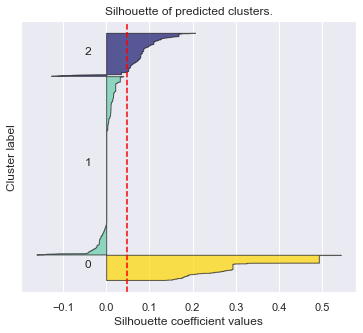

The best classification ( 3349 samples) is obtained with Confusion Map n° 4


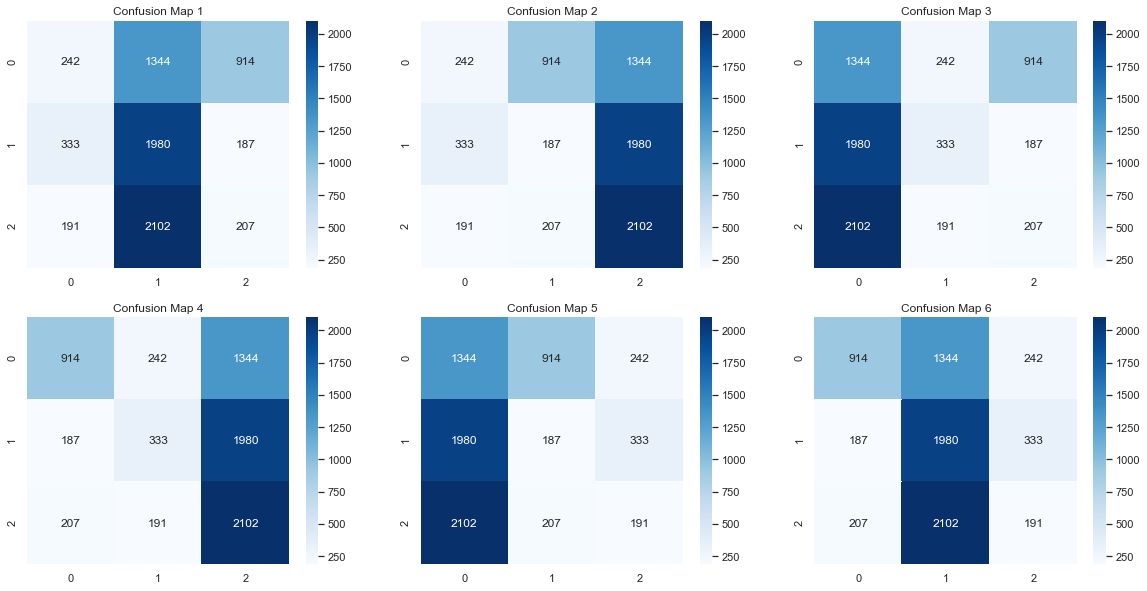

---------------------------------------------------------------------------
 Result analysis of K-Means over X50 (cosine distance) 
 ---------------------------------------------------------------------------



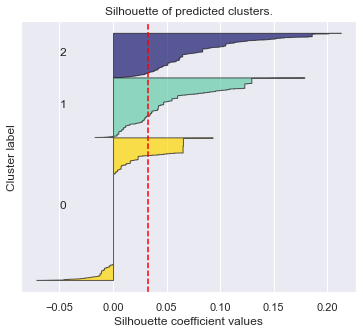

The best classification ( 3869 samples) is obtained with Confusion Map n° 6


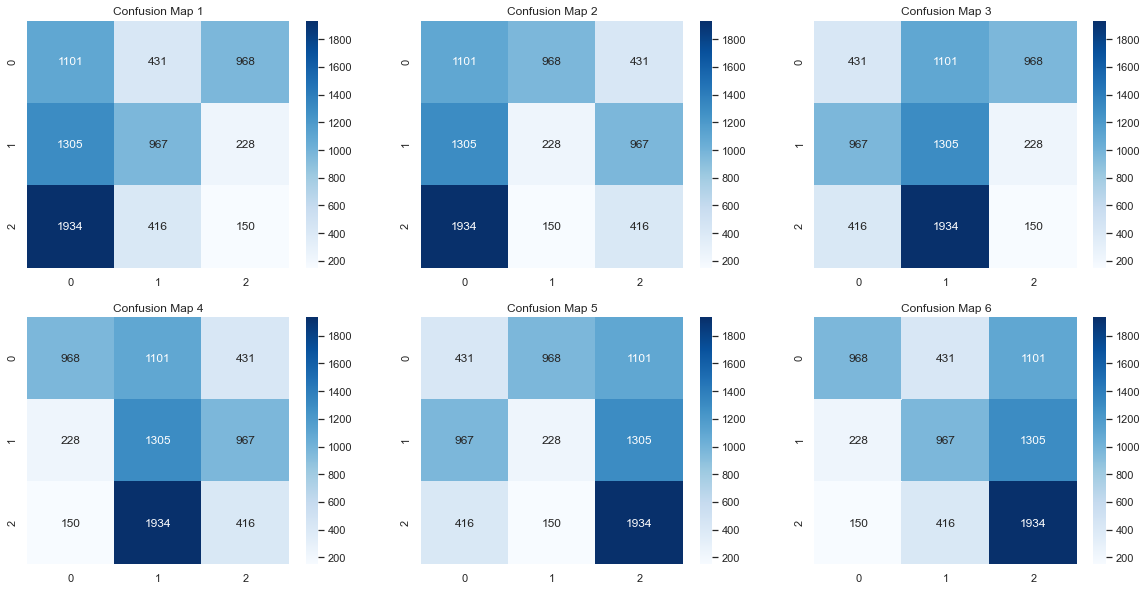

---------------------------------------------------------------------------
 Result analysis of K-Means over XFull (euclidian distance) 
 ---------------------------------------------------------------------------



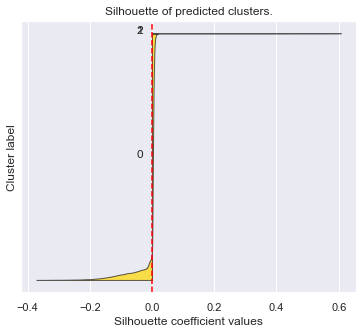

The best classification ( 2505 samples) is obtained with Confusion Map n° 3


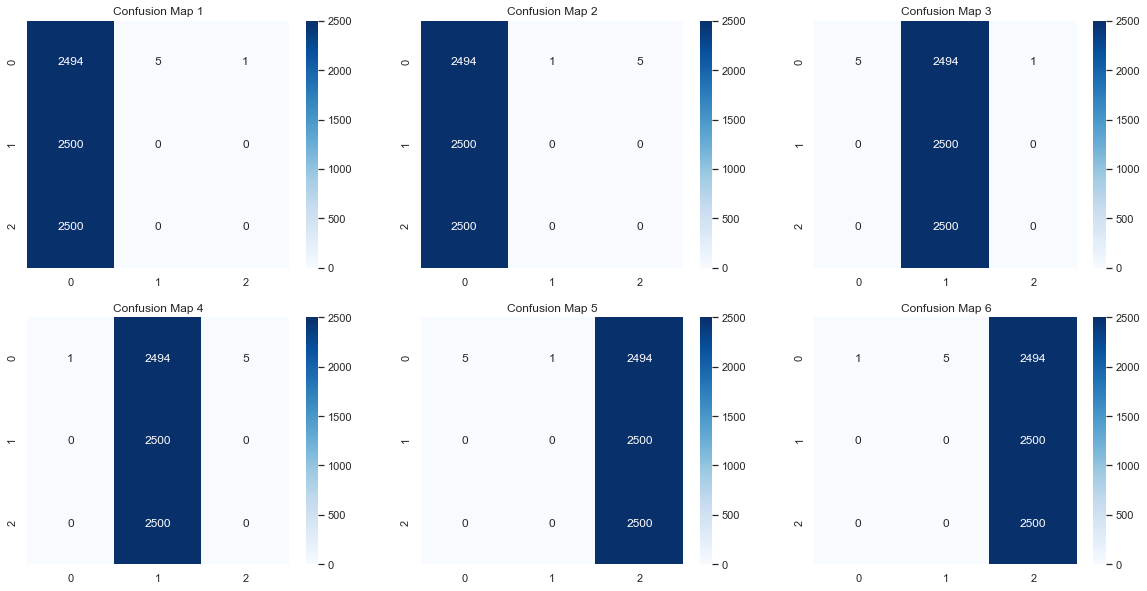

---------------------------------------------------------------------------
 Result analysis of K-Means over XFull (cosine distance) 
 ---------------------------------------------------------------------------



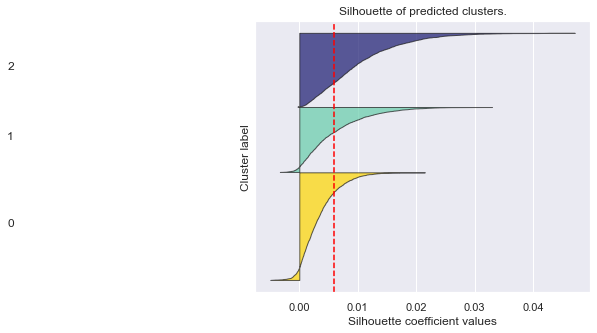

The best classification ( 5371 samples) is obtained with Confusion Map n° 6


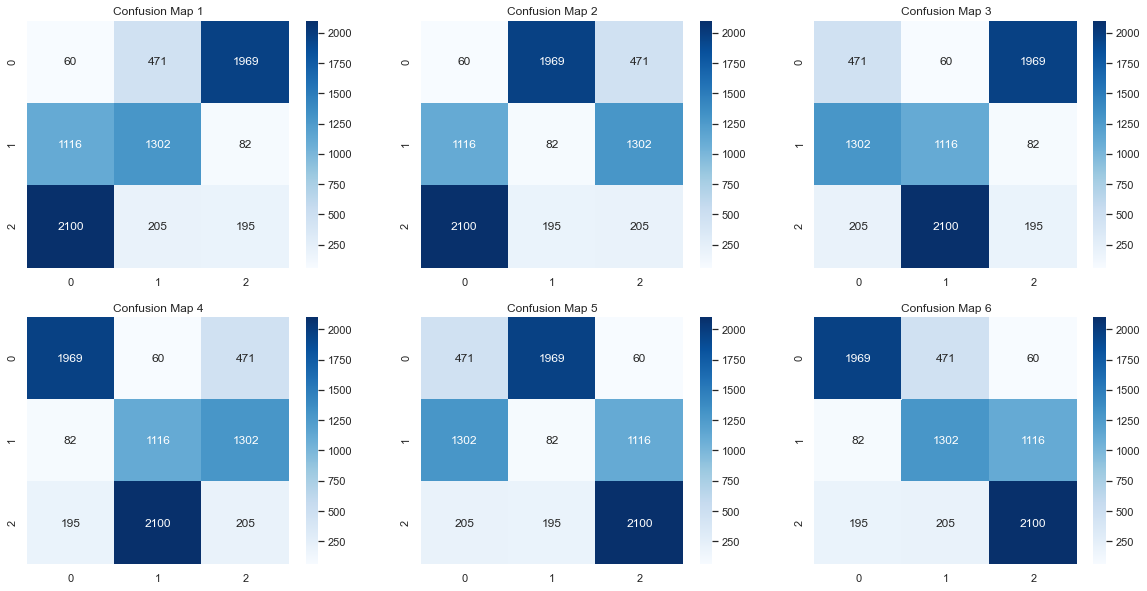

In [21]:

"""
CELL N°7 : K-MEANS RESULT ANALYSIS
[To do] If your K-Means is well implemented, run this cell to produce the graphs. Feel free to modify the code 
        if needed. 
"""

from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn.metrics import confusion_matrix
from itertools import permutations
import seaborn as sns; sns.set()
        
"""--------------------------------------------------------------------------------------------------
Draw silhouettes of clusters
    - X [MxN]: data coordinates
    - clusters [Mx]: cluster assignation of each data point
--------------------------------------------------------------------------------------------------"""
def silhouetteVisualization(X, clusters, metric='euclidean'):
    colors = iter(['gold','mediumaquamarine','midnightblue'])
    fig    = plt.figure(figsize=(6,5))
    ax     = fig.add_subplot(111)

    silhouette_avg           = silhouette_score(X, clusters, metric=metric)
    sample_silhouette_values = silhouette_samples(X, clusters, metric=metric)
    y_lower = 10

    # Create a subplot with 1 row and 2 columns
    n_clusters = (np.unique(clusters)).shape[0]
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[clusters == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper        = y_lower + size_cluster_i

        ax.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=next(colors),edgecolor='k', 
                          alpha=0.7)
    
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax.set_title("Silhouette of predicted clusters.")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    plt.show()
    

""" -----------------------------------------------------------------------------------------
Confusion Matrix resulting of the clustering
INPUT : 
    - data : intitial data dictionnary
    - clusters [Mx] : cluster assignation of each data point
----------------------------------------------------------------------------------------- """ 
def confusionMatrixVisualization(data, clusters): 
    
    target = []
    for label in data: 
        target += [label]*len(data[label]['title'])
    
    originalLabels = set(target)
    dic        = {}
    for idx, label in enumerate(originalLabels): 
        dic[label] = idx
    target_bin = [dic.get(n, n) for n in target]
    
    allPermutations = permutations(range(len(dic)))
    WellClassified = []
    
    f, axes = plt.subplots(2, 3, figsize=(20,10))
    rowPlot = 0
    for idx, permutation in enumerate(allPermutations):
        
        newTarget = [permutation[int(x)] for x in clusters]
                
        cm = confusion_matrix(target_bin, newTarget)
        WellClassified.append(sum(cm[i,i] for i in range(cm.shape[0])))        
        
        ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[rowPlot, idx%3])
        ax.set_title('Confusion Map ' + str(idx+1))
        if idx%3 ==2 : 
            rowPlot += 1
    print('The best classification (', str(np.max(WellClassified)), 'samples) is obtained with Confusion Map n°', 
          str( np.argmax(WellClassified)+1))
    plt.show()

print('-'*75 + '\n', "Result analysis of K-Means over X50 (euclidian distance) \n", '-'*75 + '\n')
silhouetteVisualization(X50, clustersEuclidian50, metric='cosine')
confusionMatrixVisualization(data, clustersEuclidian50)

print('-'*75 + '\n', "Result analysis of K-Means over X50 (cosine distance) \n", '-'*75 + '\n')
silhouetteVisualization(X50, clustersCosine50, metric='cosine')
confusionMatrixVisualization(data, clustersCosine50)

print('-'*75 + '\n', "Result analysis of K-Means over XFull (euclidian distance) \n", '-'*75 + '\n')
silhouetteVisualization(XFull, clustersEuclidianFull, metric='cosine')
confusionMatrixVisualization(data, clustersEuclidianFull)

print('-'*75 + '\n', "Result analysis of K-Means over XFull (cosine distance) \n", '-'*75 + '\n')
silhouetteVisualization(XFull, clustersCosineFull, metric='cosine')
confusionMatrixVisualization(data, clustersCosineFull)

<br>
<font size=5 color=#009999> <b>3.3 - THE REAL WORLD IS SCARY</b> <br>
FIND AN EFFICIENT WAY TO REDUCE THE DIMENSIONS OF XFULL WIHOUT LOOSING TOO MUCH INFORMATION...
</font> <br> <br>

At this stage, you should have noticed that processing the entire <samp>XFull</samp> data matrix is very slow in comparison to the <samp>X50</samp> data matrix. (Remember that we are working with only a small part of the data set: 5000 documents/topic, 3 topics, only the questions titles and not the answers, etc.). Could you image the time and ressources needed to process a new <samp>XReeeeallyBIG</samp> data matrix constructed as <samp>XFull</samp> but over the entire data set?

Up to now we proposed to work with the <samp>X50</samp> data matrix as compromise. But... can we do better than <samp>X50</samp>? 

<div class="alert alert-warning">
<b>[Question 5] Reduce the dimensions of <samp>XFull</samp> </b> <br>
Compute a new document matrix named <samp>Xreduced50</samp> obtained by applying a truncated SVD with $k=50$ on the <samp>XFull</samp> matrix. Then, use the K-Means algorithm with $K=3$ and <samp>dist='cosine'</samp> to retrieve the original 3 document clusters. <br>
Comment your results (+/- 10 lines).
</div> 

Computing K-Means over Xreduced50 (cosine distance)...

 ---------------------------------------------------------------------------
 Result analysis of K-Means over Xreduced50 (cosine distance) 
 ---------------------------------------------------------------------------



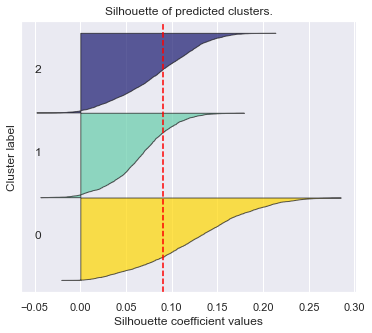

The best classification ( 6851 samples) is obtained with Confusion Map n° 3


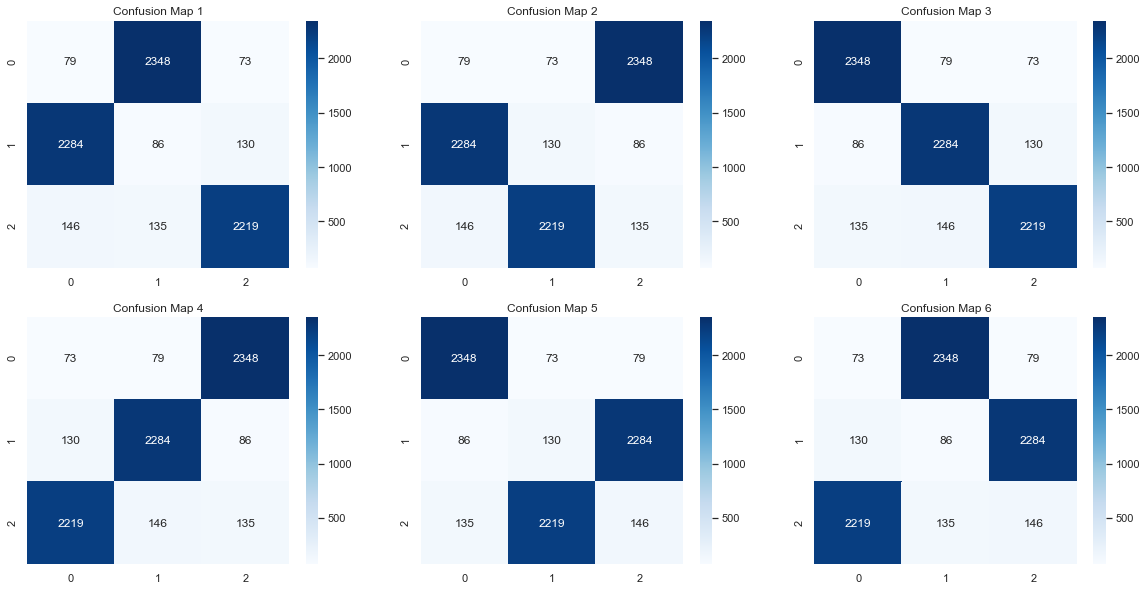

In [22]:
"""
CELL N°8 : REDUCE THE DIMENSIONS OF XFULL
[To do] It is your turn to play to answer to this open question ;-) 
"""
from scipy.sparse import csr_matrix
#truncate with k=50
SVD=TruncatedSVD(n_components=50)
Xreduced50=SVD.fit_transform(XFull)

#convert to sparse matrix in order to match dtype with X50 and XFull
Xreduced50_csr=csr_matrix(Xreduced50)

print("Computing K-Means over Xreduced50 (cosine distance)...")
clustersCosineReduced, centroidsCosineReduced = KMeans(Xreduced50_csr, 3, 4, dist = 'cosine')

print('\n','-'*75 + '\n', "Result analysis of K-Means over Xreduced50 (cosine distance) \n", '-'*75 + '\n')
silhouetteVisualization(Xreduced50, clustersCosineReduced, metric='cosine')
confusionMatrixVisualization(data, clustersCosineReduced)

<strong>Answer :</strong> Cette méthode est la plus efficace qui ait été vue jusqu'à présent, avec une proportion de classifications correctes de 91.3%. Les deux principaux atouts de cette classification contrecarrent les défauts de la classification précédente avec 50 mots sélectionnes ou avec XFull qui a un nombre de dimensions très élevé. Les voici :
<ul>
    <li>Cette classification utilise bien tous les mots disponibles ce qui, on l'a vu, permet d'améliorer grandement ses résultats (commentaires de l'exercice précédent)</li>
    <li>Comme la dimension de Xreduced50 n'est pas trop élevée par rapport à celle de XFull, l'algorithme K-Means souffre moins de la curse of dimensionnality qui fait baisser le ratio de la variance sur la moyenne, rendant plus difficile l'attribution du bon cluster. Cette sensibilité faisant partie des désavantages de la méthode K-Means, la diminution des dimensions améliore l'efficacité de la méthode !